# 1. Подготовка к работе

In [1]:
# Подгружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

%matplotlib inline

In [2]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (18, 8),
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
    }
)

sns.set_style("whitegrid")
sns.set_palette("RdGy", 10)

# 2. Загрузка данных

Имеется следующая информация:
### **olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей**  
customer_id — позаказный идентификатор пользователя  
customer_unique_id — уникальный идентификатор пользователя  (аналог номера паспорта)  
customer_zip_code_prefix — почтовый индекс пользователя  
customer_city — город доставки пользователя  
customer_state — штат доставки пользователя 

### **olist_orders_dataset.csv —  таблица заказов**  
order_id — уникальный идентификатор заказа (номер чека)  
customer_id — позаказный идентификатор пользователя  
order_status — статус заказа  
order_purchase_timestamp — время создания заказа  
order_approved_at — время подтверждения оплаты заказа  
order_delivered_carrier_date — время передачи заказа в логистическую службу  
order_delivered_customer_date — время доставки заказа  
order_estimated_delivery_date — обещанная дата доставки   

**Уникальные статусы заказов в таблице olist_orders_dataset:**  
created — создан  
approved — подтверждён  
invoiced — выставлен счёт  
processing — в процессе сборки заказа  
shipped — отгружен со склада  
delivered — доставлен пользователю  
unavailable — недоступен  
canceled — отменён

### **olist_order_items_dataset.csv —  товарные позиции, входящие в заказы**  
order_id — уникальный идентификатор заказа (номер чека)  
order_item_id — идентификатор товара внутри одного заказа  
product_id — ид товара (аналог штрихкода)  
seller_id — ид производителя товара  
shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price — цена за единицу товара  
freight_value — вес товара  

In [3]:
# Считываем данные

path_to_olist_customers_dataset   = 'olist_customers_dataset.csv'
path_to_olist_orders_dataset      = 'olist_orders_dataset.csv'
path_to_olist_order_items_dataset = 'olist_order_items_dataset.csv'

customers_data   = pd.read_csv(path_to_olist_customers_dataset)
orders_data      = pd.read_csv(path_to_olist_orders_dataset)
order_items_data = pd.read_csv(path_to_olist_order_items_dataset)

### Предварительное исследование данных таблицы customers_data

In [4]:
# Проверим первые 5 строк
customers_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# Посмотрим размер данных
customers_data.shape

(99441, 5)

In [6]:
# Посмотрим тип переменных
customers_data.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
# Проверим наличие пропущенных значений
customers_data.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
# Проверим наличие дубликатов
customers_data.duplicated().sum()

0

### Предварительное исследование данных таблицы orders_data

In [9]:
# Проверим первые 5 строк
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
# Посмотрим размер данных
orders_data.shape

(99441, 8)

In [11]:
# Посмотрим тип переменных
orders_data.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
# Приведем нужные столбцы к формату даты
orders_data[orders_data.columns[3:8]] = (orders_data[orders_data.columns[3:8]]).apply(pd.to_datetime)

In [13]:
# Проверим тип переменных
orders_data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [14]:
# Проверим наличие пропущенных значений
orders_data.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Видим, что имеется 160 заказов, у которых отсутствует время подтверждения оплаты заказа, 1783 - с отсутствующим временем передачи заказа в логистическую службу, 2965 - с отсутствующим временем доставки заказа.

In [15]:
# Проверим наличие дубликатов
orders_data.duplicated().sum()

0

### Создание таблицы purchases_data с покупками на основе таблицы orders_data

In [16]:
# Найдем количество заказов по статусам
orders_data.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [17]:
# Найдем количество заказов по статусам в процентах
orders_data.order_status.value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

Видим, что основная часть заказов доставлена пользователю - 97%.  

Посмотрим, есть ли доставленные заказы, у которых отсутствует информация о времени подтверждения оплаты заказа / передачи заказа в логистическую службу / доставки заказа.

In [18]:
delivered_without_date = orders_data[orders_data.order_status == 'delivered'] \
    .query("order_approved_at.isnull() or \
            order_delivered_carrier_date.isnull() or \
            order_delivered_customer_date.isnull()")
delivered_without_date.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
84999,2babbb4b15e6d2dfe95e2de765c97bce,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [19]:
# Посмотрим размер данных
delivered_without_date.shape

(23, 8)

In [20]:
# Посмотрим, какую часть составляют заказы с пустыми значениями от всех со статусом "delivered".
delivered_without_date.shape[0] / \
    orders_data[orders_data.order_status == 'delivered'].shape[0]

0.00023839631833164038

Доля заказов с пустыми ячейками дат составляет менее 0.05%, поэтому мы можем удалить их без особого влияния на анализ, так как у нас имеется большое количество данных со статусом "delivered" (96478). Но сначала проверим, сколько строк датафрейма с пустыми значениями от общего числа строк в датафрейме без фильтрации по статусу.

In [21]:
orders_data.query("order_approved_at.isnull() or \
                   order_delivered_carrier_date.isnull() or \
                   order_delivered_customer_date.isnull()").shape[0] / orders_data.shape[0]

0.02996751842801259

Таких значений менее 3%. Поэтому мы можем удалить все строки с пустыми значениями из датафрейма. При этом останутся заказы только со статусами "delivered" и "canceled", так как во всех остальных промежуточных статусах будет отсутствовать order_delivered_carrier_date. Однако то, что мы не учитываем эти заказы как покупку, можно обосновать тем, что в итоге они могут быть отменены, а деньги за заказ не будут получены (произойдет возврат средств). Например, после примерки выяснится, что размер не тот, придет товар c повреждениями, товар будет идти слишком долго и так далее (более подробно причины будут рассмотрены ниже).

>В соответствии с п. 21 Постановления Правительства РФ от 27.09.2007 N 612 «Об утверждении Правил продажи товаров дистанционным способом» покупатель вправе отказаться от товара надлежащего качества в любое время до его передачи, а после передачи товара – в течение 7 дней, а также в течение трех месяцев с момента передачи товара, если в момент его доставки потребителю не была предоставлена письменная информация о порядке и сроках возврата товара.
   
Также мы не учтем заказы "delivered" с пустой ячейкой order_delivered_carrier_date, так как это следствие некорректного сбора данных и не предоставляется возможным установить причину возникновения этого (как уже выяснили ранее, такие заказы составляют мизерный процент и не повлияют на выводы).

В нашем случае за покупку будем считать исполненный договор купли-продажи:

> В силу п. 2 ст. 499 ГК РФ договор розничной купли-продажи считается исполненным с момента вручения товара покупателю, а при его отсутствии любому лицу, предъявившему квитанцию или иной документ, свидетельствующий о заключении договора или об оформлении доставки товара, если иное не предусмотрено законом, иными правовыми актами или договором либо не вытекает из существа обязательства.

**Тогда за покупку считается заказ, который доставлен и оплачен.**  

При этом за "доставлен" мы подразумеваем именно статус "delivered", так как наличие времени order_delivered_carrier_date не гарантирует, что покупка была совершена, так как она могла быть отменена уже после доставки (не подошел товар / товар с браком). Приведем пример таких заказов. 

In [22]:
orders_data.query("order_delivered_customer_date.notnull() and order_status == 'canceled'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


**Итого**  

In [23]:
# Создадим датафрейм с покупками
purchases_data = orders_data.dropna().query("order_status == 'delivered'")
purchases_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [24]:
# Посмотрим размер данных
purchases_data.shape

(96455, 8)

In [25]:
# Проверим, какую долю от первоначального датафрейма мы учитываем как покупки
purchases_data.shape[0] / orders_data.shape[0]

0.9699721442865619

### Предварительное исследование данных таблицы order_items_data

In [26]:
# Проверим первые 5 строк
order_items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [27]:
# Посмотрим размер данных
order_items_data.shape

(112650, 7)

In [28]:
# Посмотрим тип переменных
order_items_data.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [29]:
# Приведем нужные столбцы к формату даты
order_items_data.shipping_limit_date = pd.to_datetime(order_items_data.shipping_limit_date)

In [30]:
# Проверим тип переменных
order_items_data.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [31]:
# Проверим наличие пропущенных значений
order_items_data.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [32]:
# Проверим наличие дубликатов
order_items_data.duplicated().sum()

0

# Анализ данных

## 1. Найдем количество пользователей, совершивших покупку только один раз

In [33]:
# Создадим общий датафрейм покупок и пользователей
purchases_customers = purchases_data.merge(customers_data, how='left', on='customer_id')
purchases_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [34]:
# Удостоверимся, что соединение произошло корректно
purchases_customers.shape

(96455, 12)

In [35]:
# Найдем количество пользователей, которые совершили покупку только один раз

single_purchase_count = purchases_customers \
    .groupby('customer_unique_id', as_index=False) \
    .agg(count_purchases=('customer_id', 'count')) \
    .query('count_purchases == 1') \
    .count_purchases.sum()
single_purchase_count

90536

**90536 пользователей совершили покупку только один раз**

### Дополнительно

In [36]:
# Найдем количество уникальных значений уникального идентификатора пользователя
customer_count = purchases_customers.customer_unique_id.nunique()
customer_count

93336

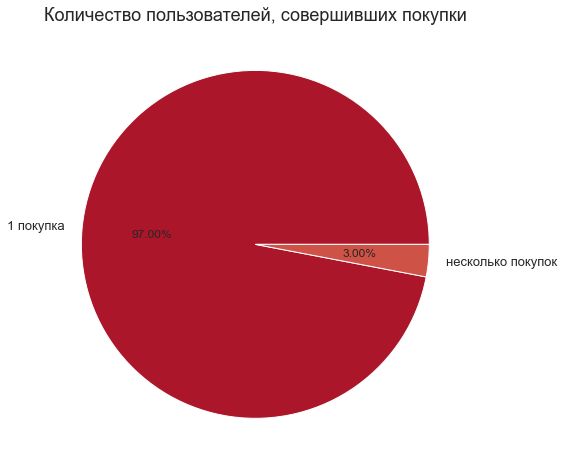

In [37]:
# Визуализируем распределение пользователей по количеству покупок

plt.pie([single_purchase_count, customer_count - single_purchase_count],
        labels=['1 покупка', 'несколько покупок'], autopct='%.2f%%')
plt.title('Количество пользователей, совершивших покупки')
plt.show()

Видим, что большая часть пользователей совершили всего 1 покупку.

## 2. Вычислим, сколько заказов в месяц в среднем не доставляется по разным причинам, выведем детализацию по причинам

Нас интересуют заказы, где order_delivered_customer_date пусто.

In [38]:
# Создаем датафрейм недоставленных заказов
undelivered_orders_data = orders_data.query("order_delivered_customer_date.isnull()")
undelivered_orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


In [39]:
# Посмотрим количество недоставленных заказов
undelivered_orders_data.shape[0]

2965

In [40]:
# Оставим только нужные столбцы и создадим столбцы с годом и номером месяца создания заказа

undelivered_orders = undelivered_orders_data.loc[:]
undelivered_orders = undelivered_orders[['order_id', 'order_status', 'order_purchase_timestamp']]
undelivered_orders['year'] = undelivered_orders.order_purchase_timestamp.dt.year
undelivered_orders['month'] = undelivered_orders.order_purchase_timestamp.dt.month
undelivered_orders.head()

,order_id,order_status,order_purchase_timestamp,year,month
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017,4
44,ee64d42b8cf066f35eac1cf57de1aa85,shipped,2018-06-04 16:44:48,2018,6
103,0760a852e4e9d89eb77bf631eaaf1c84,invoiced,2018-08-03 17:44:42,2018,8
128,15bed8e2fec7fdbadb186b57c46c92f2,processing,2017-09-03 14:22:03,2017,9
154,6942b8da583c2f9957e990d028607019,shipped,2018-01-10 11:33:07,2018,1


In [41]:
# Посчитаем количество месяцев в нашем датафрейме
month_count = undelivered_orders.groupby('year', as_index=False).agg({'month': 'nunique'}).month.sum()
month_count

24

In [42]:
# Посмотрим, сколько заказов в месяц в среднем не доставляется по разным причинам

round(undelivered_orders
      .groupby(['year', 'month'], as_index=False)
      .agg(order_count=('order_purchase_timestamp', 'count'))
      .order_count.mean())

124

**В месяц в среднем не доставляется по разным причинам 124 заказа**

**Выведем детализацию по статусам**

In [43]:
# Выведем детализацию по статусам

undelivered_orders_per_month = undelivered_orders.order_status.value_counts().to_frame() / month_count
undelivered_orders_per_month = undelivered_orders_per_month \
    .reset_index() \
    .rename(columns={'index': 'order_status', 'order_status': 'order_count_per_month'})
undelivered_orders_per_month

,order_status,order_count_per_month
0,shipped,46.125000
1,canceled,25.791667
2,unavailable,25.375000
3,invoiced,13.083333
4,processing,12.541667
5,delivered,0.333333
6,created,0.208333
7,approved,0.083333


In [44]:
# Проверим, что совпадает с общим числом
undelivered_orders_per_month.order_count_per_month.sum().round()

124.0

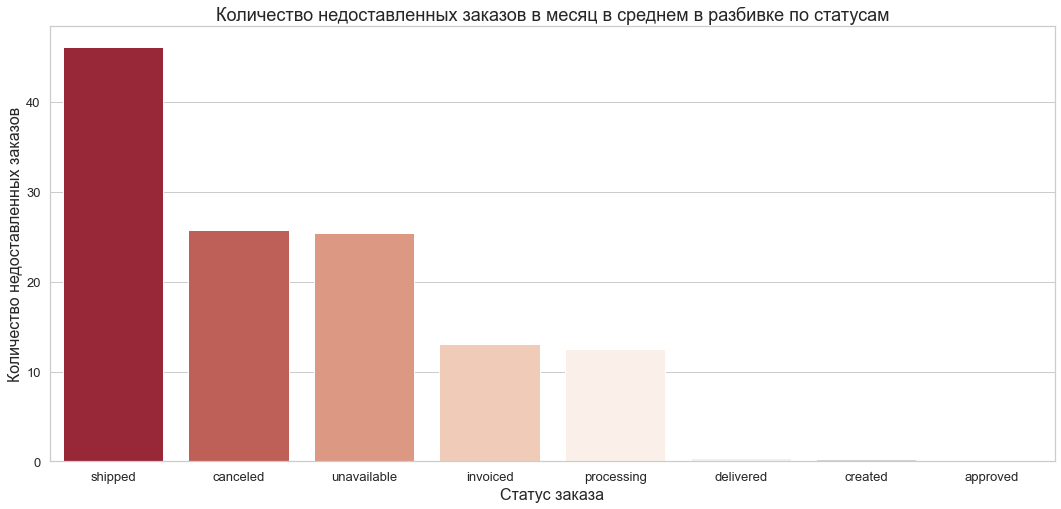

In [45]:
# Построим диаграмму

sns.barplot(data=undelivered_orders_per_month,
            x='order_status', y='order_count_per_month')
plt.xlabel('Статус заказа')
plt.ylabel('Количество недоставленных заказов')
plt.title('Количество недоставленных заказов в месяц в среднем в разбивке по статусам')
plt.show()

Таким образом, большинство заказов, которые не доставлены пользователю, обладают статусами:
- отгружен со склада - уже в логистической службе (ЛС), но еще не передан покупателю
- отменён - отменен со стороны покупателя / продавца / ЛС
- недоступен - заказ потерян, информация о нем отсутствует / уточняется
- выставлен счёт - еще не приступили к сборке заказа
- в процессе сборки заказа - еще не передали в ЛС  

Также совсем небольшая доля приходится на заказы со статусами:
- доставлен пользователю - наличие таких заказов среди заказов, у которых отсутствует время доставки, можно объяснить некорректным сбором данных, так как их совсем маленькая доля от всех заказов   
- создан - заказ только создали, еще не успели оплатить  
- подтверждён - заказ подтвержден, но еще не приступили к дальнейшему этапу  

### Дополнительно
Далее интересно посмотреть более подробно **детализацию по причинам**, по которым не был доставлен заказ. Посмотрим, какие еще пустые ячейки присутствуют в разбивке по статусам, чтобы понять, на какой именно стадии находится заказ со стороны логистики, для этого посмотрим на заказы без разбивки по месяцам. 

In [46]:
# Группируем по статусам, но без разбивки по месяцам

undelivered_by_status = undelivered_orders \
    .groupby('order_status', as_index=False) \
    .agg(order_count=('order_id', 'count')) \
    .sort_values('order_count', ascending=False)
undelivered_by_status

,order_status,order_count
6,shipped,1107
1,canceled,619
7,unavailable,609
4,invoiced,314
5,processing,301
3,delivered,8
2,created,5
0,approved,2


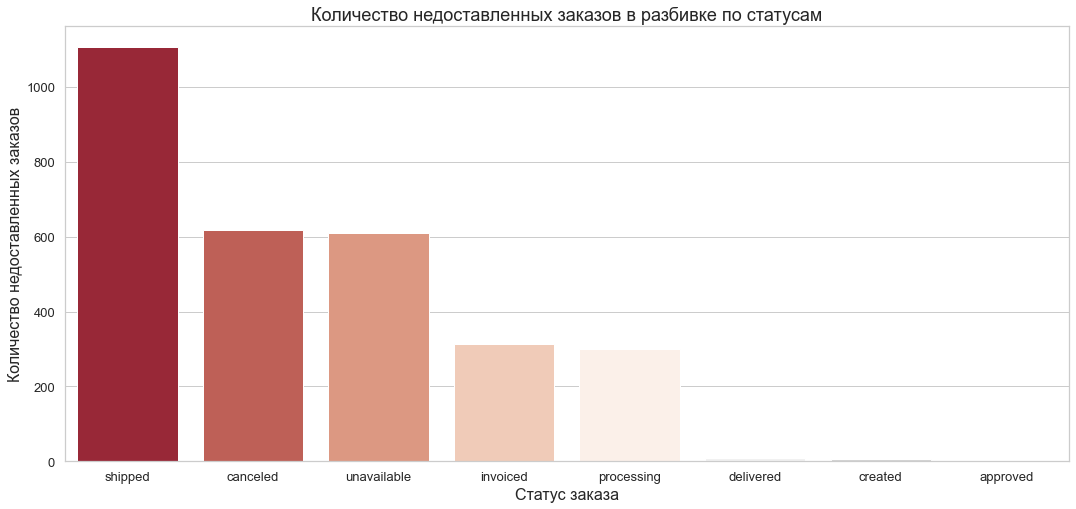

In [47]:
# Построим диаграмму

sns.barplot(data=undelivered_by_status, x='order_status', y='order_count')
plt.xlabel('Статус заказа')
plt.ylabel('Количество недоставленных заказов')
plt.title('Количество недоставленных заказов в разбивке по статусам')
plt.show()

In [48]:
# Ищем количество пустых ячеек в разбивке по статусам

na_by_status = undelivered_orders_data \
    .set_index('order_status') \
    .isna() \
    .groupby('order_status') \
    .agg({'order_approved_at': 'sum',
          'order_delivered_carrier_date': 'sum',
          'order_delivered_customer_date': 'sum'}) \
    .sort_values('order_delivered_customer_date', ascending=False) \
    .reset_index()
na_by_status

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,shipped,0,0,1107
1,canceled,141,550,619
2,unavailable,0,609,609
3,invoiced,0,314,314
4,processing,0,301,301
5,delivered,0,1,8
6,created,5,5,5
7,approved,0,2,2


In [49]:
# Заказы со статусом, которые составлют малую долю, объединим

missing_values_by_status = pd.concat([na_by_status[0:5], pd.DataFrame(na_by_status.loc[5:8].sum()).transpose()], 
                                      ignore_index=True)
missing_values_by_status.loc[5, 'order_status'] = 'another'
missing_values_by_status

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,shipped,0,0,1107
1,canceled,141,550,619
2,unavailable,0,609,609
3,invoiced,0,314,314
4,processing,0,301,301
5,another,5,8,15


По диаграмме видно, что:
- заказы со статусом **shipped (отгружен со склада)** уже оплачены и переданы в логистическую службу (ЛС) (отсутствует только дата доставки пользователю), а значит, они могут быть не доставлены по следующим причинам:
    - заказ еще в пути 
    - заказ затерялся/задержался при доставке
    - получателя не было на месте, будет повторная попытка вручения
    - другое
- заказы со статусом **canceled (отменён)** отменялись в некоторых случаях еще до момента оплаты (отсутствуют все даты), но в основном уже после подтверждения оплаты, но до передачи в ЛС (есть только дата подтверждения оплаты), причиной этого могло служить:
    - долгое ожидание передачи в ЛС
    - был найден товар по более привлекательной цене / с меньшим сроком ожидания
    - передумали покупать
    - товара не оказалось на складе
    - другое
- заказы со статусом **canceled (отменён)** также отменялись и после передачи в ЛС (отсутствует только дата доставки пользователю), причиной могло быть:
    - слишком долгое ожидание
    - был найден товар по более привлекательной цене / с меньшим сроком ожидания
    - передумали покупать
    - получатель не принял товар, повторная попытка вручения не предусмотрена
    - товар был поврежден во время транспортировки
    - другое
- заказы со статусом **unavailable (недоступен)** были оплачены, но далее информация отсутствует (есть только дата подтверждения оплаты), причины:
    - уточняется статус заказа
    - заказ потерян
    - уточняется наличие товаров
    - другое
- заказы со статусом **invoiced (выставлен счёт)**: по диаграмме пустых значений видно, что оплата поступила (есть дата подтверждения оплаты), но еще не успели приступить к сборке заказа, соответственно, еще не передали в ЛС
- заказы со статусом **processing (в процессе сборки заказа)**: оплата поступила, заказ собирается, но еще не передан в ЛС
- заказы с другими статусами, которые только созданы, подтверждены и доставлены (вследствие некорректного сбора данных)

Таким образом можно поделить на следующие относительно логистики причины, по которым заказ не доставлен: 
   - заказ передан в ЛС, но еще не дошел до покупателя
   - заказ отменен до оплаты
   - заказ отменен до передачи в ЛС
   - заказ отменен после передачи в ЛС
   - заказ еще не был передан в ЛС
   - другое (создан, подтвержден, доставлен (вследствие некорректного сбора данных) можно объединить, так как слишком маленькая доля заказов с этими статусами)

In [50]:
# Заказы, соответствующие вышеперечисленным причинам

reason = missing_values_by_status.loc[:]
reason['in_logistics_service'] = \
    reason.query("order_status not in ['canceled', 'another']").order_delivered_customer_date - \
    reason.order_delivered_carrier_date

reason['canceled_before_payment'] = \
    reason.query("order_status == 'canceled'").order_approved_at

reason['canceled_before_ls'] = \
    reason.query("order_status == 'canceled'").order_delivered_carrier_date - \
    reason.canceled_before_payment

reason['canceled_after_ls'] = \
    reason.query("order_status == 'canceled'").order_delivered_customer_date - \
    reason.order_delivered_carrier_date

reason['in_stock'] = \
    reason.query("order_status not in ['canceled', 'another']").order_delivered_carrier_date - \
    reason.order_approved_at

reason['another'] = \
    reason.query("order_status == 'another'").order_delivered_customer_date

In [51]:
# Посчитаем общую сумму заказов, соответствующих каждой из причин

reason = reason.fillna(0).iloc[:, 4:10]
undelivered_by_reason = reason.sum() \
    .to_frame(name='order_count') \
    .reset_index() \
    .rename(columns={'index': 'reason'}) \
    .sort_values('order_count', ascending=False)
undelivered_by_reason

,reason,order_count
4,in_stock,1224
0,in_logistics_service,1107
2,canceled_before_ls,409
1,canceled_before_payment,141
3,canceled_after_ls,69
5,another,15


In [52]:
# Проверим, что в ходе расчетов никакие заказы не были потеряны
print('Количество заказов в первоначальном датафрейме:',
      undelivered_orders.shape[0])
print('Общее количество заказов в конце анализа:',
      undelivered_by_reason.order_count.sum())

Количество заказов в первоначальном датафрейме: 2965
Общее количество заказов в конце анализа: 2965


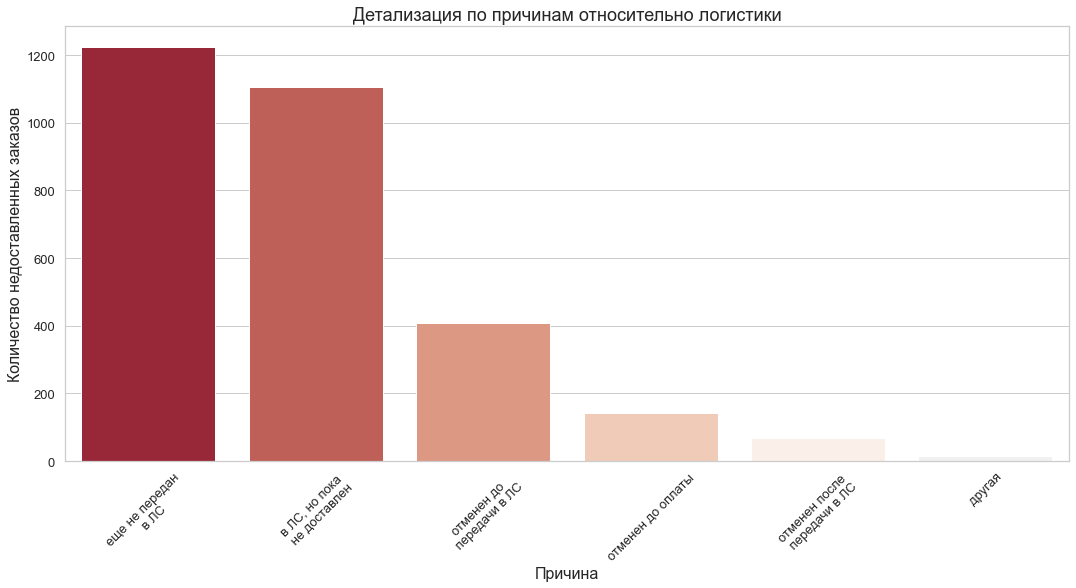

In [53]:
# Построим диаграмму

sns.barplot(data=undelivered_by_reason, x='reason', y='order_count')
plt.xticks((0, 1, 2, 3, 4, 5),
           ('еще не передан\n в ЛС', 'в ЛС, но пока\n не доставлен', 'отменен до\n передачи в ЛС',
            'отменен до оплаты', 'отменен после\n передачи в ЛС', 'другая'))
plt.xticks(rotation=45)
plt.xlabel('Причина')
plt.ylabel('Количество недоставленных заказов')
plt.title('Детализация по причинам относительно логистики')
plt.show()

Таким образом, мы видим, что большинство заказов еще не были переданы в логистическую службу (ЛС).  
Также большое количество заказов уже переданы в ЛС, но еще не доставлены по разным причинам.  
Некоторые заказы были отменены, что могло произойти как со стороны пользователя и продавца, так и со стороны логистической службы.  
И в небольшом количестве присутствуют заказы, которые недоставлены по другим причинам.  
Варианты возникновения таких причин были рассмотрены выше.

## 3. По каждому товару определим, в какой день недели товар чаще всего покупается

Ранее уже был создан датафрейм с покупками, напомню, что **покупкой** считается заказ, который **доставлен** и **оплачен** (также были удалены все строки с пустыми ячейками, так как они составляли мизерный процент от общего числа заказов).

In [54]:
# Создадим общий датафрейм с покупками и товарами
purchase_items = order_items_data.merge(purchases_data, how='left', on='order_id')
purchase_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [55]:
# Удостоверимся, что соединение произошло корректно
purchase_items.shape

(112650, 14)

In [56]:
# Создадим датафрейм с товарами и днями неделями, когда был создан заказ с этим товаром

purchase_items['week_day'] = purchase_items.order_purchase_timestamp.dt.day_name()
purchase_items_by_weekday = purchase_items[['product_id', 'order_purchase_timestamp', 'week_day']]
purchase_items_by_weekday.head()

,product_id,order_purchase_timestamp,week_day
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,Sunday
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,Wednesday
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,Saturday


**И, наконец, по каждому товару определим, в какой день недели товар чаще всего покупается.**

In [57]:
# Cгруппируем по товарам и дням недели, посчитаем количество, отсортируем по убыванию,
# таким образом, для каждого товара наибольшее значение количества покупок будет сверху,
# сгруппируем по товарам, возьмем для каждого только верхнее значение - оно же наибольшее,
# для наглядности отсортируем

max_purchase_items_by_weekday = purchase_items_by_weekday \
    .groupby(['product_id', 'week_day'], as_index=False) \
    .agg(count_purchases=('order_purchase_timestamp', 'count')) \
    .sort_values('count_purchases', ascending=False) \
    .groupby('product_id', as_index=False) \
    .head(1) \
    .sort_values('count_purchases', ascending=False)
max_purchase_items_by_weekday.head()

,product_id,week_day,count_purchases
15592,422879e10f46682990de24d770e7f83d,Wednesday,93
35742,99a4788cb24856965c36a24e339b6058,Monday,91
40173,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19704,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12740,368c6c730842d78016ad823897a372db,Friday,67


In [58]:
# Проверим, что ничего не потеряли
print('Куплено уникальных товаров по нашим рассчетам:',
      max_purchase_items_by_weekday.shape[0])
print('Куплено уникальных товаров из первоначального датафрейма:',
      purchase_items.dropna().product_id.nunique())
print('Всего товаров:', purchase_items.product_id.nunique())
print('Количество некупленных уникальных товаров:', purchase_items.product_id.nunique() -
      purchase_items.dropna().product_id.nunique())

Куплено уникальных товаров по нашим рассчетам: 32210
Куплено уникальных товаров из первоначального датафрейма: 32210
Всего товаров: 32951
Количество некупленных уникальных товаров: 741


### Дополнительно

In [59]:
# Посмотрим, какие самые популярные дни недели у товаров

popular_weekdays = max_purchase_items_by_weekday \
    .groupby('week_day', as_index=False) \
    .agg(count_products=('count_purchases', 'count')) \
    .sort_values('count_products', ascending=False)
popular_weekdays

,week_day,count_products
1,Monday,5609
0,Friday,5198
5,Tuesday,4870
6,Wednesday,4729
4,Thursday,4560
3,Sunday,3745
2,Saturday,3499


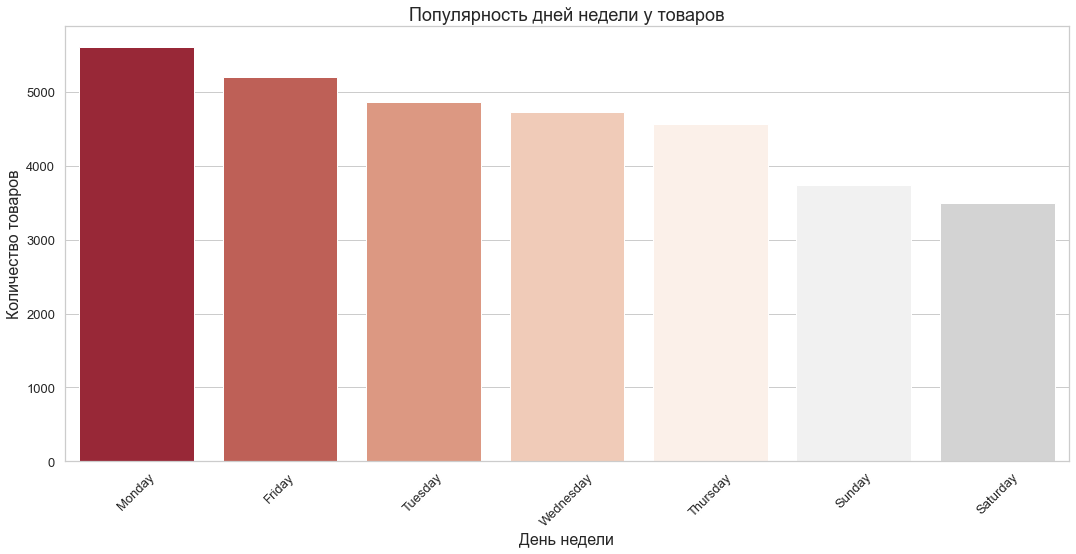

In [60]:
# Построим диаграмму

sns.barplot(data=popular_weekdays, x='week_day', y='count_products')
plt.xticks(rotation=45)
plt.title('Популярность дней недели у товаров')
plt.xlabel('День недели')
plt.ylabel('Количество товаров')
plt.show()

Чаще всего товары покупают в понедельник, а реже всего на выходных. Это можно объяснить тем, что на выходных часто у рабочих сокращенный рабочий день, тяжелее связаться с продавцом для уточнения информации по товару, реже доставляются товары на выходных,. Поэтому на выходных сокращается количество, а в понедельник, в первый рабочий день, продавец отвечает пользователю и он делает заказ.

##  4. Найдем, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам) 

In [61]:
# Ранее созданный датафрейм покупок и пользователей
purchases_customers.head() 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [62]:
# Добавим колонки с названием месяца и количеством недель в нем
purchases_customers['month_name'] = purchases_customers.order_purchase_timestamp.dt.month_name()
purchases_customers['weeks_in_month'] = purchases_customers.order_purchase_timestamp.dt.days_in_month / 7
purchases_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_name,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,February,4.000000


**И, наконец, найдем, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)**

In [63]:
# Сгруппируем по пользователям и месяцам, найдем количество покупок и разделим его на количество недель

purchase_count_per_week = purchases_customers \
    .groupby(['customer_unique_id', 'month_name', 'weeks_in_month'], as_index=False) \
    .agg(purchase_count=('customer_id', 'count'))

purchase_count_per_week = purchase_count_per_week \
    .assign(avg_purchase_count_per_week = 
            purchase_count_per_week.purchase_count / purchase_count_per_week.weeks_in_month)

purchase_count_per_week.head()

,customer_unique_id,month_name,weeks_in_month,purchase_count,avg_purchase_count_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1,0.233333


### Дополнительно

In [64]:
# Найдем, какие средние значения покупок в неделю встречаются больше всего

avg_value_count = purchase_count_per_week \
    .groupby('avg_purchase_count_per_week', as_index=False) \
    .agg(avg_value_count=('customer_unique_id', 'count')) \
    .sort_values('avg_value_count', ascending=False)
avg_value_count['percent_avg'] = avg_value_count.avg_value_count / \
    avg_value_count.avg_value_count.sum()
avg_value_count

,avg_purchase_count_per_week,avg_value_count,percent_avg
0,0.225806,56962,0.598768
1,0.233333,29067,0.305544
2,0.250000,7848,0.082496
3,0.451613,712,0.007484
4,0.466667,328,0.003448
5,0.500000,159,0.001671
6,0.677419,27,0.000284
7,0.700000,13,0.000137
8,0.750000,6,0.000063
9,0.903226,4,0.000042


Видим, что количество значений среднего (покупки в неделю):
- в диапазоне от 0.225 до 0.25 сооставляет более 98%! Что неудивительно, так как если посмотреть на пункт 1 раздела анализа данных, то увидим, что первоначально у нас большая часть людей совершила всего одну покупку, а флуктуации объясняются разным количеством недель в месяцах
- в диапазоне от 0.45 до 0.5 всего около 1.3%
- более 0.5 составляет мизерная часть - менее 0.1%

## 5. Проведем когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц

Перед проведением когортного анализа определим четыре параметра.

**Признак формирования когорты:** дата первого заказа  
**Размер когорты:** временной интервал - месяц  
**Отчетный период:** январь-декабрь 2017 гг.   
**Анализируемый ключевой показатель:** CRR (Customer Retention Rate — коэффициент удержания клиентов) или RPR (или Repeat Purchase Rate — коэффициент повторных покупок) — эти метрики показывают процент клиентов, которые возвращаются для совершения повторных покупок. 

$$
Customer\ Retention\ Rate = {Количество\ клиентов\ в\ конце\ периода - Количество\ новых\ клиентов\ за\ период\over{Количество\ клиентов\ в\ начале\ расчетного\ периода}} \times 100\%   
$$

In [65]:
# Ранее созданный датафрейм покупок и пользователей
purchases_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_name,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,October,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,July,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,August,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,November,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,February,4.000000


In [66]:
# Создадим датафрейм c нужными столбцами и с месяцем-годом, когда была совершена покупка
purchases_customers['MY_order_purchase'] = purchases_customers['order_purchase_timestamp'].dt.to_period('M')
purchases_customers_df = purchases_customers[['customer_unique_id', 'order_id', 'MY_order_purchase']]
purchases_customers_df.head()

,customer_unique_id,order_id,MY_order_purchase
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02


In [67]:
# Найдем месяц-год первой покупки - это и будет наш признак формирования когорты
first_purchase = purchases_customers_df \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg(first_purchase_date=('MY_order_purchase', 'min'))
first_purchase.head()

,customer_unique_id,first_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [68]:
# Пронумеруем прошедшие периоды (количество месяцев) с момента первой покупки до повторной,
# 0 - это первый месяц наблюдения, месяц, когда была совершена первая покупка
purchases_customer_df = purchases_customers_df.merge(
    first_purchase, on='customer_unique_id')
purchases_customer_df['period'] = (purchases_customer_df.MY_order_purchase.dt.year -
                                   purchases_customer_df.first_purchase_date.dt.year) * 12 + \
    (purchases_customer_df.MY_order_purchase.dt.month -
     purchases_customer_df.first_purchase_date.dt.month)
purchases_customer_df.head()

,customer_unique_id,order_id,MY_order_purchase,first_purchase_date,period
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10,2017-09,1
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09,2017-09,0
2,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07,2018-07,0
3,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08,2018-08,0
4,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,2017-11,0


In [69]:
# Сформируем когорты,
# посчитаем количество уникальных пользователей, сделавших покупки, по датам первой покупки и периодам

cohort_df = purchases_customer_df \
    .groupby(['first_purchase_date', 'period'], as_index=False) \
    .customer_unique_id.nunique() \
    .rename(columns={'customer_unique_id': 'unique_customer_count'})
cohort_df.head()

,first_purchase_date,period,unique_customer_count
0,2016-09,0,1
1,2016-10,0,262
2,2016-10,6,1
3,2016-10,9,1
4,2016-10,11,1


In [70]:
# Посчитаем количество уникальных пользователей в нулевом периоде (начало расчетного периода) по когортам

start_month = cohort_df \
    .query('period == 0')[['first_purchase_date', 'unique_customer_count']] \
    .rename(columns={'unique_customer_count': 'unique_customer_count_start'})
start_month.head()

,first_purchase_date,unique_customer_count_start
0,2016-09,1
1,2016-10,262
10,2016-12,1
12,2017-01,715
30,2017-02,1616


In [71]:
# Найдем коэффициент удержания пользователей

cohort_data = cohort_df.merge(start_month, on='first_purchase_date')
cohort_data['rate'] = cohort_data.unique_customer_count / \
    cohort_data.unique_customer_count_start
cohort_data.loc[:, 'retetion'] = cohort_data['rate'].map('{:.2%}'.format)
cohort_data.head()

,first_purchase_date,period,unique_customer_count,unique_customer_count_start,rate,retetion
0,2016-09,0,1,1,1.000000,100.00%
1,2016-10,0,262,262,1.000000,100.00%
2,2016-10,6,1,262,0.003817,0.38%
3,2016-10,9,1,262,0.003817,0.38%
4,2016-10,11,1,262,0.003817,0.38%


In [72]:
# Создадим сводную таблицу

cohort_customer_pivot = cohort_data.pivot(index='first_purchase_date', columns = 'period', values = 'rate')
cohort_customer_pivot.columns.names = ['Период']
cohort_customer_pivot.index.names = ['Когорта по дате первой покупки']
cohort_customer_pivot.style.highlight_max(color='lightgray').format("{:.2%}", na_rep = "")

Период,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
Когорта по дате первой покупки,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.38%,,,0.38%,,0.38%,,0.38%,,0.38%,,0.38%,0.76%,0.76%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.28%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,,0.42%,0.14%,0.70%,0.42%,0.14%,0.14%,0.28%,0.42%,0.14%,
2017-02,100.00%,0.19%,0.31%,0.12%,0.43%,0.12%,0.25%,0.19%,0.06%,0.19%,0.12%,0.31%,0.12%,0.19%,0.12%,0.06%,0.06%,0.19%,,
2017-03,100.00%,0.44%,0.36%,0.40%,0.36%,0.16%,0.16%,0.32%,0.32%,0.08%,0.36%,0.12%,0.20%,0.12%,0.16%,0.24%,0.08%,0.12%,,
2017-04,100.00%,0.62%,0.22%,0.18%,0.27%,0.27%,0.35%,0.31%,0.31%,0.18%,0.27%,0.09%,0.04%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.46%,0.46%,0.29%,0.29%,0.32%,0.41%,0.14%,0.26%,0.26%,0.26%,0.35%,0.23%,0.03%,0.17%,0.20%,,,,
2017-06,100.00%,0.49%,0.40%,0.43%,0.30%,0.40%,0.36%,0.23%,0.13%,0.20%,0.30%,0.36%,0.16%,0.16%,0.23%,,,,,


По данной таблице видно, что уже во втором месяце (индексирован как 1 (первый период), первый месяц (нулевой период) - месяц, в котором была совершена покупка) наблюдается резкое падение, почти никто из клиентов не совершает никаких покупок во второй месяц (что неудивительно, ведь ранее было показано, что 97% покупателей не совершили более одной покупки). Также по выделенной ячейке можно сразу определить, что наибольший retention на третий месяц был у покупателей, совершивших первую покупку 2017-09 (подходит под условие "с января по декабрь"). Но для точности найдем индекс, соответствующий максимальному retention на третий месяц (индексирован как 2).

**Найдем когорту с самым высоким retention на 3-й месяц в период с января по декабрь.**

In [73]:
print('Когорта с самым высоким retention на 3-й месяц в период с января по декабрь -',
      cohort_customer_pivot[2].idxmax(),
      'со значением:', "{:.2%}".format(cohort_customer_pivot[2].max()))

Когорта с самым высоким retention на 3-й месяц в период с января по декабрь - 2017-09 со значением: 0.55%


### Дополнительно

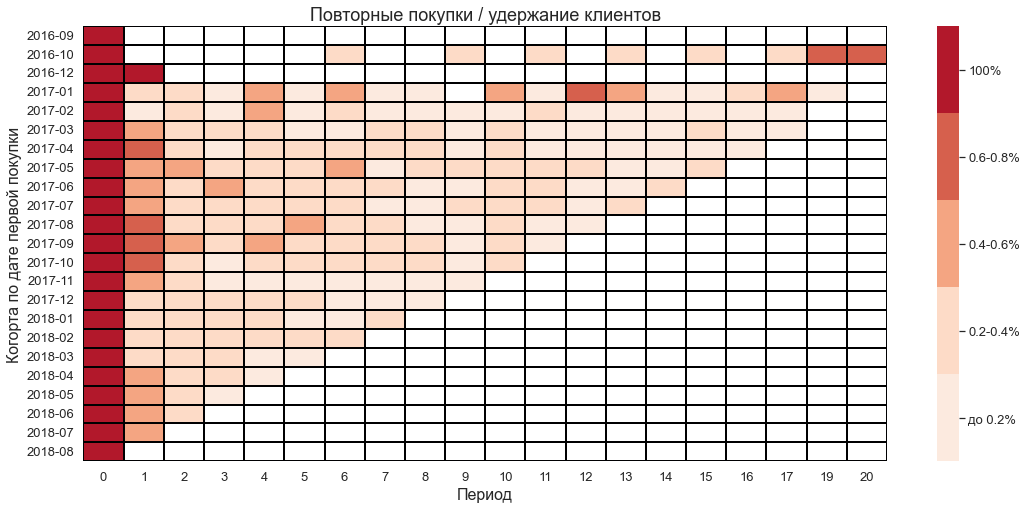

In [74]:
# Визуализируем (за 100% для визуализации берем значения больше 0.8%, так как по таблице видно, 
# что в нашем случае среди значений больше 0.8% есть только 100%)

fig, ax = plt.subplots(1,1,figsize=(18,8))
my_colors=['#fceadf', '#fddbc7', '#f4a582', '#d6604d', '#b2182b']
sns.heatmap(cohort_customer_pivot,
            cmap=my_colors, linewidth=0.01, 
            linecolor=(0.0,0.001,0.002), 
            ax=ax, vmin=0, vmax=0.01)
plt.title('Повторные покупки / удержание клиентов')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.001, 0.003, 0.005, 0.007, 0.009])
colorbar.set_ticklabels(['до 0.2%', '0.2-0.4%', '0.4-0.6%', '0.6-0.8%', '100%'])
plt.show()

Таким образом, мы видим, что в большинстве своем покупатели не совершают повторных покупок. Однако можем заметить, что процент тех, кто совершил повторную покупку во второй месяц, больше, чем в другие месяца (прямоугольники ярче). Часть пользователей совершила крайнюю покупку более, чем через год от первой.

## 6. Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию

В кластеризации выберем следующие метрики:  
R (Recency) - время от последней покупки пользователя до текущей даты  
F (Frequency) - суммарное количество покупок у пользователя за всё время  
M (Monetary) - сумма покупок за всё время

Чтобы получить оценку RFM пользователя, нам нужно сначала рассчитать оценки R, F и M по шкале от 1 (худший) до 3 (лучший).

План действий:
1. Рассчитаем R, F, M
2. Найдем границы для каждого из этих измерений
3. Присвоим оценку каждому измерению в зависимости от того, в каком диапазоне оно находится
4. Объединим баллы R, F и M, чтобы получить балл RFM
5. Сопоставим оценки RFM с сегментами
6. Создадим таблицу с описанием каждого RFM-сегмента.

In [75]:
# Создадим полный датафрейм с покупками, пользователями и товарами
full_data = purchases_data \
    .merge(customers_data, on='customer_id') \
    .merge(order_items_data, on='order_id')
full_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [76]:
# Проверим корректность соединения
full_data.shape

(110173, 18)

Необходимо найти текущую дату, в рамках этого задания будет логичным брать самую позднюю дату из представленных, не включая обещанную дату доставки. Считаем, что данные обновляются регулярно. 

In [77]:
now_date = full_data[['order_purchase_timestamp', 'order_approved_at',
                      'order_delivered_carrier_date', 'order_delivered_customer_date']].max().max()
now_date

Timestamp('2018-10-17 13:22:46')

### 1. Рассчитаем R, F, M

In [78]:
# Отберем нужные столбцы и создадим столбец с количеством дней, прошедших с покупки
df = full_data.groupby(['order_id', 'customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
    .agg({'price': 'sum'})
df['time_since_purchase'] = df['order_purchase_timestamp'].apply(lambda x: (now_date - x).days)
df.head()

,order_id,customer_unique_id,order_purchase_timestamp,price,time_since_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90,399
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90,539
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00,275
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99,70
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90,619


In [79]:
# Находим количество дней, прошедших с последней покупки, количество покупок и потраченную сумму для каждого
# пользователя
rfm_df = df.groupby('customer_unique_id', as_index=False) \
    .agg({'time_since_purchase': 'min', 'order_id': 'count',  'price': 'sum'}) \
    .rename(columns={'time_since_purchase': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'})
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90
2,0000f46a3911fa3c0805444483337064,585,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00


In [80]:
# Посмотрим численное описание (понадобится для задания границ)
rfm_df.describe()

,Recency,Frequency,Monetary
count,93336.000000,93336.000000,93336.000000
mean,285.796692,1.033417,141.621663
std,152.552006,0.209098,215.714143
min,48.000000,1.000000,0.850000
25%,162.000000,1.000000,47.650000
50%,267.000000,1.000000,89.700000
75%,394.000000,1.000000,154.692500
max,762.000000,15.000000,13440.000000


### 2. Найдем границы для каждого из этих измерений

Cоздавать диапазоны будем двумя способами:

### Способ 1:
Фиксированные диапазоны - самостоятельно зададим диапазоны (для Frequency), так как по прошлым заданиям мы видели, что основная часть совершила только одну покупку, поэтому разделить по равному количеству пользователей уже не получится.

In [81]:
# Напомним распределение по количеству покупок
rfm_df.Frequency.value_counts(normalize=True)

1     0.970001
2     0.027556
3     0.001939
4     0.000300
5     0.000096
6     0.000054
7     0.000032
9     0.000011
15    0.000011
Name: Frequency, dtype: float64

Распределим следующим образом:  
- 1 покупка - 1 балл
- 2 покупки - 2 балла
- 3 покупки - 3 балла

### Способ 2:
Квантили — создадим 3 равных части по количеству пользователей (для Recency и Monetary).  
Для Recency: чем больше значение, тем ниже балл, так как большее значение означает, что времени с последней покупки прошло больше, то есть:
- 1 диапазон - 3 балла
- 2 диапазон - 2 балла
- 3 диапазон - 1 балла

Для Monetary: наоборот, чем больше сумма, которую потратил пользователь, тем больше балл, получаем:
- 1 диапазон - 1 балл
- 2 диапазон - 2 балла
- 3 диапазон - 3 балла

In [82]:
# Найдем диапазоны
ranges = rfm_df[['Recency', 'Monetary']].quantile([.3333, .6666]).to_dict()
ranges

{'Recency': {0.3333: 197.0, 0.6666: 338.0},
 'Monetary': {0.3333: 58.9, 0.6666: 127.9}}

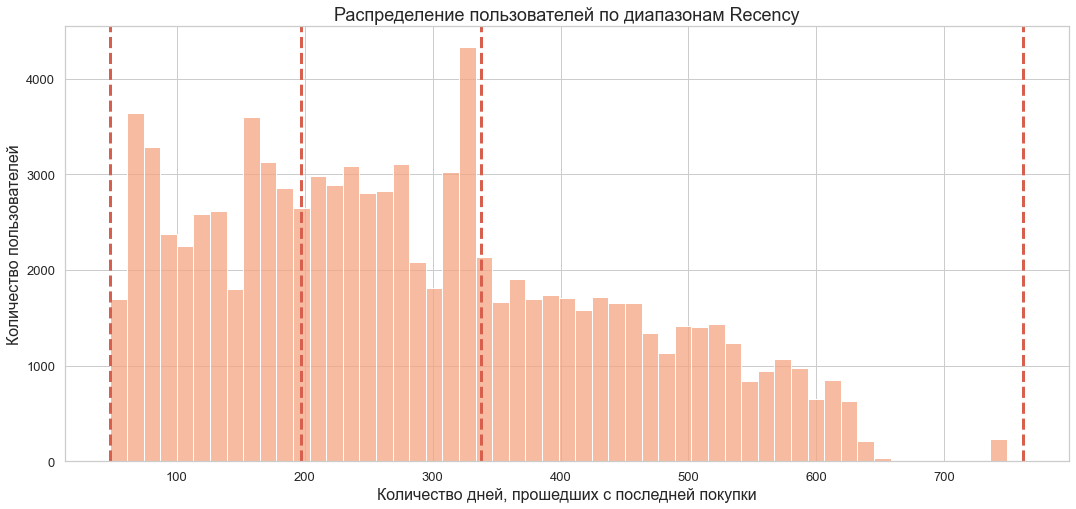

In [83]:
# Визуализируем, как распределились пользователи по полученным диапазонам Recency

sns.histplot(data=rfm_df, x='Recency', color='#f4a582', bins=55)
plt.axvline(x=48, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=197.0, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=338.0, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=762, linewidth=3, color='#d6604d', linestyle='--')
plt.title('Распределение пользователей по диапазонам Recency')
plt.xlabel('Количество дней, прошедших с последней покупки')
plt.ylabel('Количество пользователей')
plt.show()

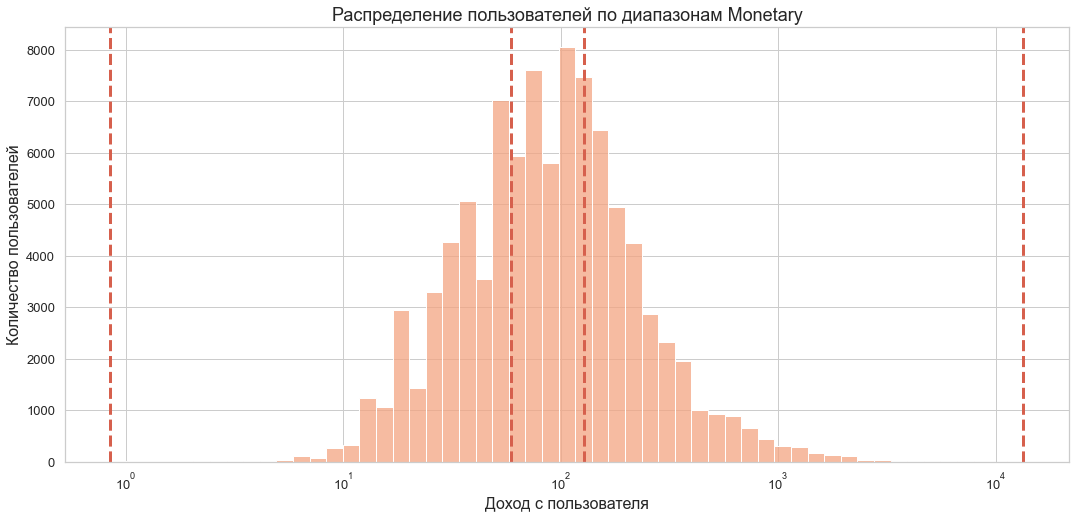

In [84]:
# Визуализируем, как распределились пользователи по полученным диапазонам

sns.histplot(data=rfm_df, x='Monetary',
             log_scale=True, color='#f4a582', bins=55)
plt.axvline(x=0.85, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=58.9, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=127.9, linewidth=3, color='#d6604d', linestyle='--')
plt.axvline(x=13440, linewidth=3, color='#d6604d', linestyle='--')
plt.title('Распределение пользователей по диапазонам Monetary')
plt.xlabel('Доход с пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что данное распределение пользователей по диапазонам для Recency и Monetary нам подходит.

### 3. Присвоим оценку каждому измерению в зависимости от того, в каком диапазоне оно находится

In [85]:
# Создаем функции, присваивающие оценки на основе рассуждений, представленных выше

def r_score(x):
    if x <= ranges['Recency'][.3333]:
        return 3
    elif x <= ranges['Recency'][.6666]:
        return 2
    else:
        return 1


def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    else:
        return 3


def m_score(x):
    if x <= ranges['Monetary'][.3333]:
        return 1
    elif x <= ranges['Monetary'][.6666]:
        return 2
    else:
        return 3

In [86]:
# Получаем оценки для каждого пользователя

rfm_df['R'] = rfm_df['Recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['Frequency'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['Monetary'].apply(lambda x: m_score(x))
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,585,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00,2,1,3


### 4. Объединим баллы R, F и M, чтобы получить балл RFM

In [87]:
# Объединяем оценки R, F и M в оценку RFM
rfm_df['RFM_Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,585,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00,2,1,3,213


Оценка RFM дает нам $3^3=27$ сегментов.

In [88]:
print('В нашем случае:', rfm_df.RFM_Score.nunique())

В нашем случае: 26


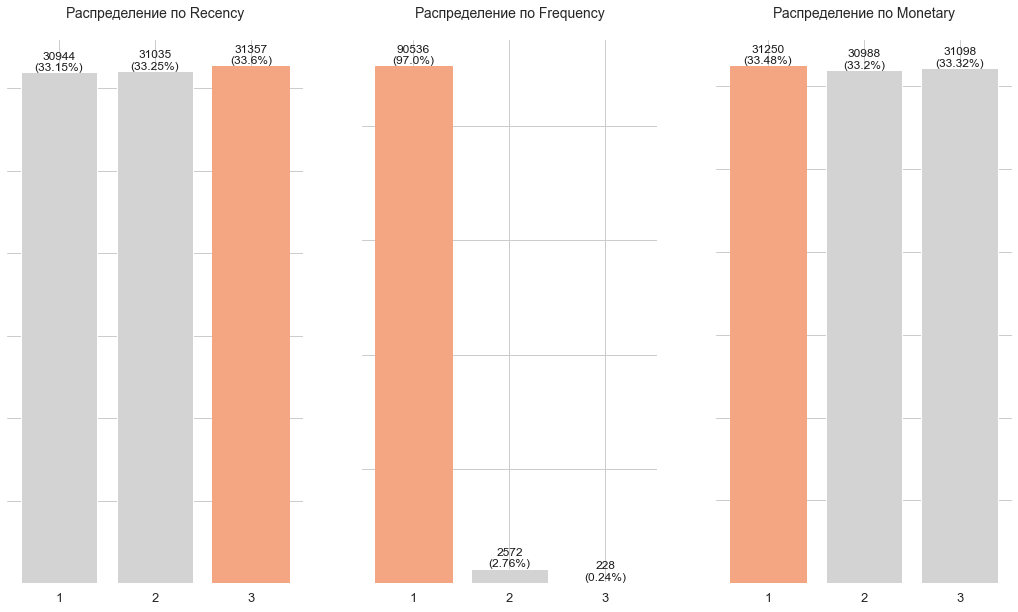

In [89]:
# Посмотрим распределение пользователей по Recency, Frequency, Monetary

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))

for i, p in enumerate(['R', 'F', 'M']):
    parameters = {'R': 'Recency', 'F': 'Frequency', 'M': 'Monetary'}
    y = rfm_df[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='lightgray')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение по {}\n'.format(parameters[p]),
                 fontsize=14)

    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('#f4a582')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 3,
                '{}\n({}%)'.format(int(value), round(float(value * 100 / y.sum()), 2)),
                ha='center',
                va='bottom',
                color='k')
plt.setp(axes, xticks=[1, 2, 3])
plt.show()

Как и предполагалось, мы видим, что если по недавности и доходу с пользователя количество пользователей кажется равномерно распределенным, так как мы и задавали такое условие, то по количеству покупок сильное отклонение идет в сторону одной покупки.  

Посмотрим, как распределяется M-значение по RF-значению (доход по количеству и недавности покупок).

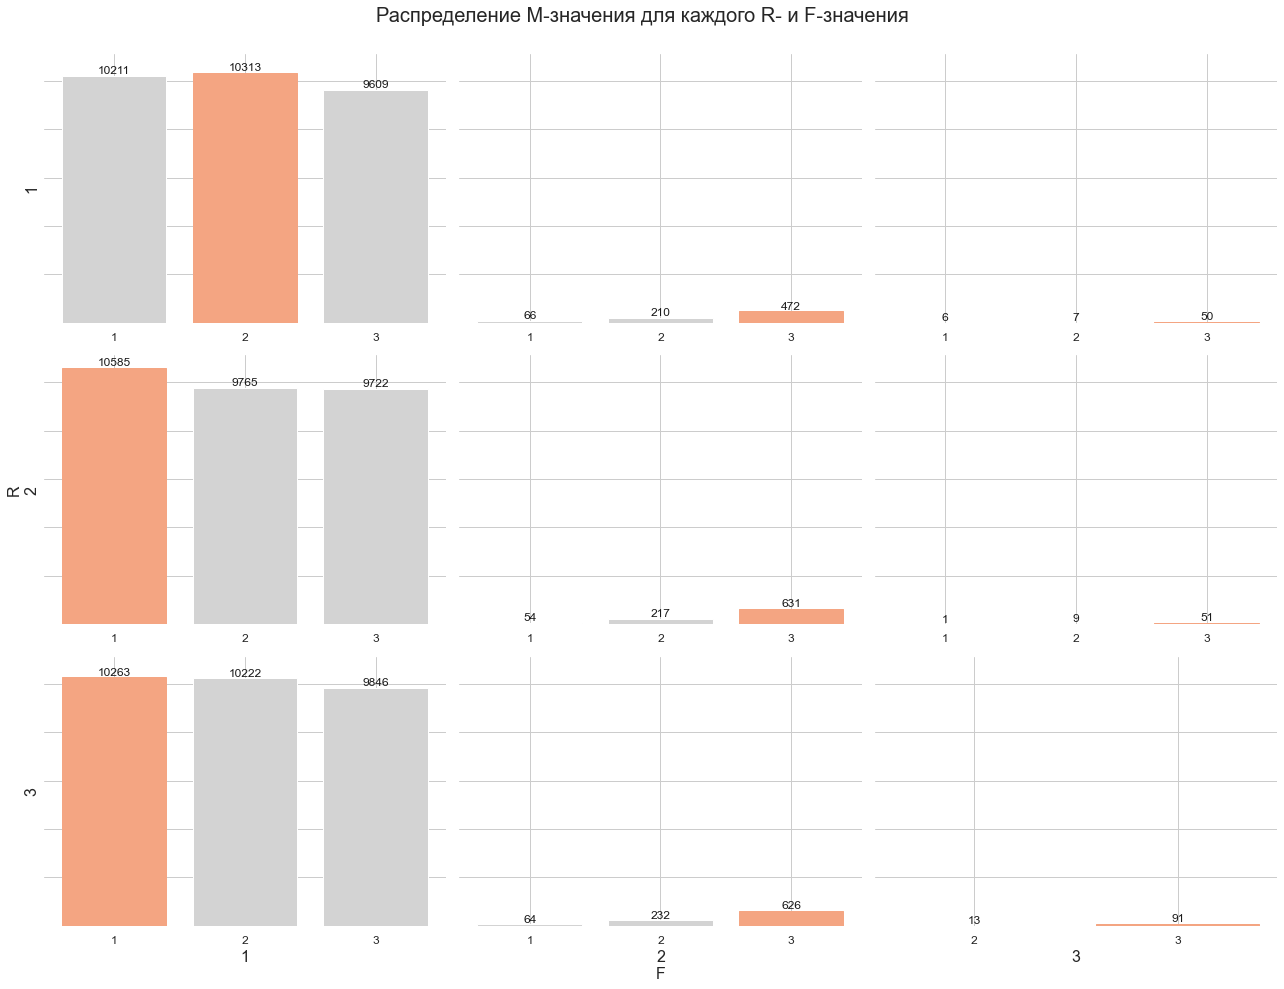

In [90]:
# Построим распределение M-значения по RF-значению

fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(18, 14))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = rfm_df[(rfm_df['R'] == r) & (rfm_df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='lightgray')
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=12)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('#f4a582')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')

fig.suptitle(
    'Распределение M-значения для каждого R- и F-значения\n', fontsize=20)
plt.tight_layout()
plt.show()

Видим, что то, как давно была совершена одна крайняя покупка, не особо влияет на распределение M (поведение схоже при разных R).  
Среди пользователей, которые совершили две и более покупок (второй и третий столбцы) больше пользователей с M = 3, чем с M < 3, то есть количество покупок повлияло на доход от этих пользователей. В то время как, среди пользователей с одной покупкой большая часть пользователей имеет значение M < 3. Однако среди пользователей, совершивших одну покупку, количество тех, кто делал ее на маленькую, на среднюю и на большую сумму примерно одинаково (это объясняется нашим первоначальным распределением, так как основной вклад в количество пользователей вносили все же пользователи, которые совершили одну покупку).

### 5. Сопоставим оценки RFM с сегментами

Однако с таким количеством сегментов сложно проводить анализ, поэтому разделим эти сегменты по следующему принципу.    

**Уходящие:**
- R = 1, F = 1, M = X: **Одноразовые пользователи**. Скорее всего, это уже потерянные пользователи: они покупали давно и мало.
- R = 1, F = 2, M = X: **Уходящие редкие пользователи**. Эти пользователи сделали несколько покупок, а потом перестали покупать. Их можно попытаться вернуть.
- R = 1, F = 3, M = X: **Уходящие лояльные пользователи**. Этих пользователей обязательно нужно попытаться вернуть: покупали давно, но много товаров.

**Спящие:**
- R = 2, F = 1/2, M = X: **Спящие разовые / редкие пользователи**. Эти пользователи еще помнят о сервисе, можно попытаться их расшевелить.
- R = 2, F = 3, M = X: **Спящие лояльные пользователи**. Не так давно они делали много покупок, а сейчас перестали. Нужно попытаться вернуть их. 

**Постоянные:**
- R = 3, F = 1, M = X: **Новички**. Нужно поддержать интерес этих пользователей.
- R = 3, F = 2, M = 1/2: **Постоянные с маленьким и средним чеком**. Нужно попытаться увеличить средний чек. 
- R = 3, F = 2, M = 3: **Постоянные с высоким чеком**. Эти пользователи покупали недавно, совершили несколько покупок, заплатили много.
- R = 3, F = 3, M = 1/2: **Лояльные пользователи**. Покупали недавно и много. Можно попытаться увеличить сумму чека.
- R = 3, F = 3, M = 3: **ТОП-пользователи**. Самые лояльные и активные пользователи, которых нужно беречь.

In [91]:
# Делим на сегменты

segt_map = {
    r'11[1-3]': 'Одноразовые пользователи',
    r'12[1-3]': 'Уходящие редкие пользователи',
    r'13[1-3]': 'Уходящие лояльные пользователи',
    r'2[1-2][1-3]': 'Спящие разовые / редкие пользователи',
    r'23[1-3]': 'Спящие лояльные пользователи',
    r'31[1-3]': 'Новички',
    r'32[1-2]': 'Постоянные с маленьким и средним чеком',
    r'323': 'Постоянные с высоким чеком',
    r'33[1-2]': 'Лояльные пользователи',
    r'333': 'ТОП-пользователи',
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90,3,1,3,313,Новички
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90,3,1,1,311,Новички
2,0000f46a3911fa3c0805444483337064,585,1,69.00,1,1,2,112,Одноразовые пользователи
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99,1,1,1,111,Одноразовые пользователи
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00,2,1,3,213,Спящие разовые / редкие пользователи


In [92]:
# Посмотрим, сколько сегментов получилось в нашем случае
rfm_df.Segment.nunique()

10

In [93]:
# Проверим, что никого не упустили
rfm_df.Segment.isna().sum()

0

In [94]:
# Посмотрим, какой сегмент является лидером и наоборот по количеству пользователей и доходу

rfm = rfm_df.groupby(['Segment'], as_index=False) \
    .agg({'Recency': 'count', 'Monetary': 'sum'}) \
    .rename(columns={'Monetary': 'Revenue', 'Recency': 'Customer_count'}) \
    .sort_values('Customer_count', ascending=False) \
    .reset_index(drop=True)
rfm.style.highlight_max(['Customer_count', 'Revenue'], color='#f4a582') \
    .highlight_min(['Customer_count', 'Revenue'], color='#fceadf')

,Segment,Customer_count,Revenue
0,Спящие разовые / редкие пользователи,30974,4203474.020000
1,Новички,30331,4267803.730000
2,Одноразовые пользователи,30133,4238289.450000
3,Уходящие редкие пользователи,748,180325.710000
4,Постоянные с высоким чеком,626,206407.720000
5,Постоянные с маленьким и средним чеком,296,24965.020000
6,ТОП-пользователи,91,49612.650000
7,Уходящие лояльные пользователи,63,21831.620000
8,Спящие лояльные пользователи,61,24379.630000
9,Лояльные пользователи,13,1309.950000


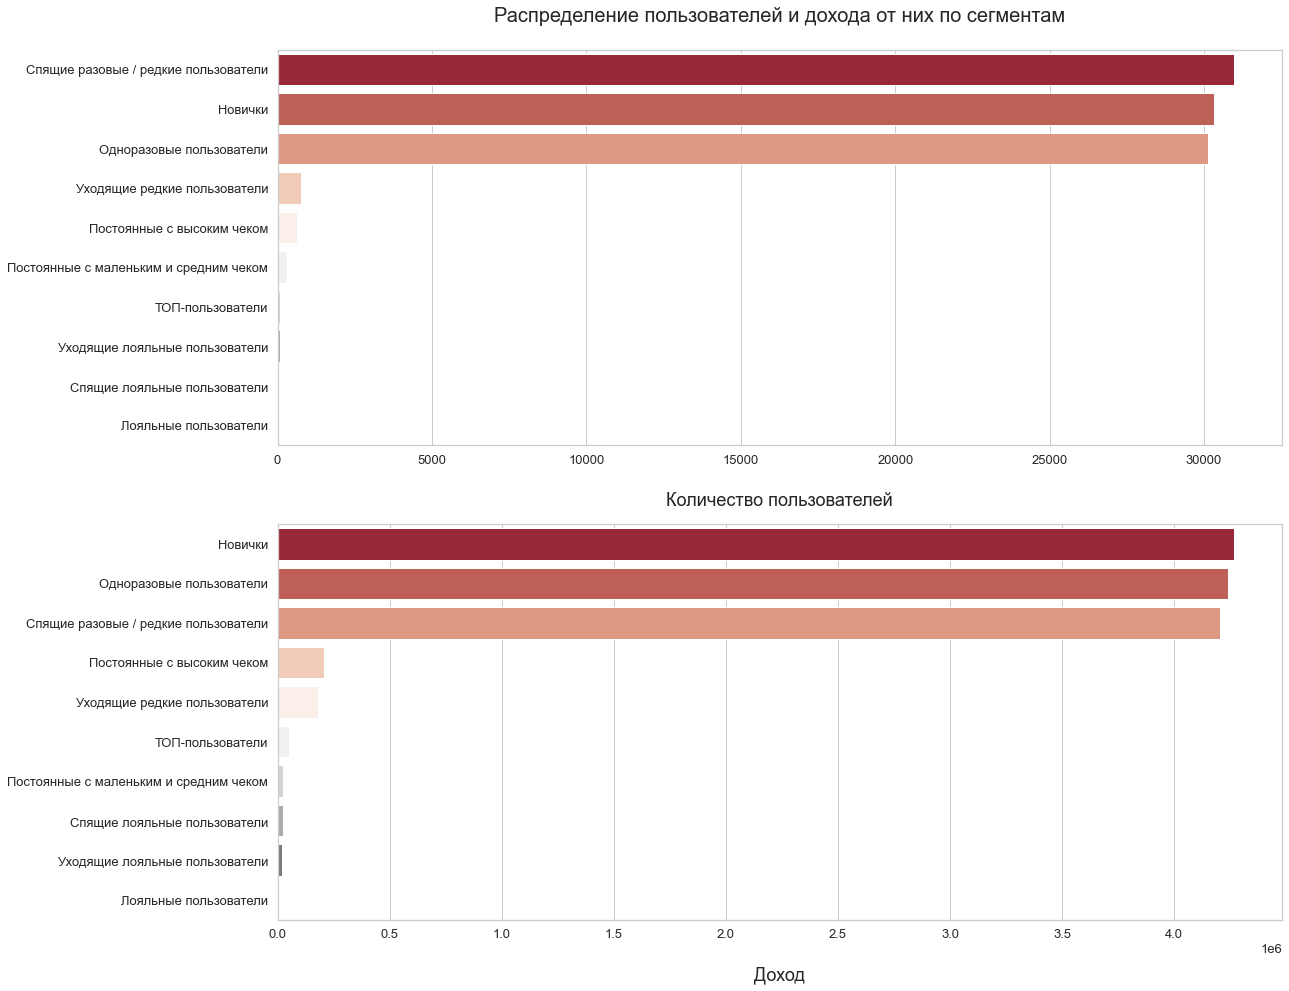

In [95]:
# Визуализируем распределение количества пользователей и дохода от них по сегментам

fig = plt.subplots(figsize=(18, 16))
plt.subplot(2, 1, 1)
sns.barplot(data=rfm, y='Segment', x='Customer_count', orient = 'h')
plt.xlabel('\nКоличество пользователей', fontsize=18)
plt.ylabel('')
plt.title('Распределение пользователей и дохода от них по сегментам\n', fontsize=20)
plt.subplot(2, 1, 2)
sns.barplot(data=rfm.sort_values('Revenue', ascending=False), y='Segment', x='Revenue', orient = 'h')
plt.xlabel('\nДоход', fontsize=18)
plt.ylabel('')
plt.show()

Снова видим, что преобладают те, кто совершил одну покупку, чтобы детальнее рассмотреть остальные сегменты, построим диаграмму без них.

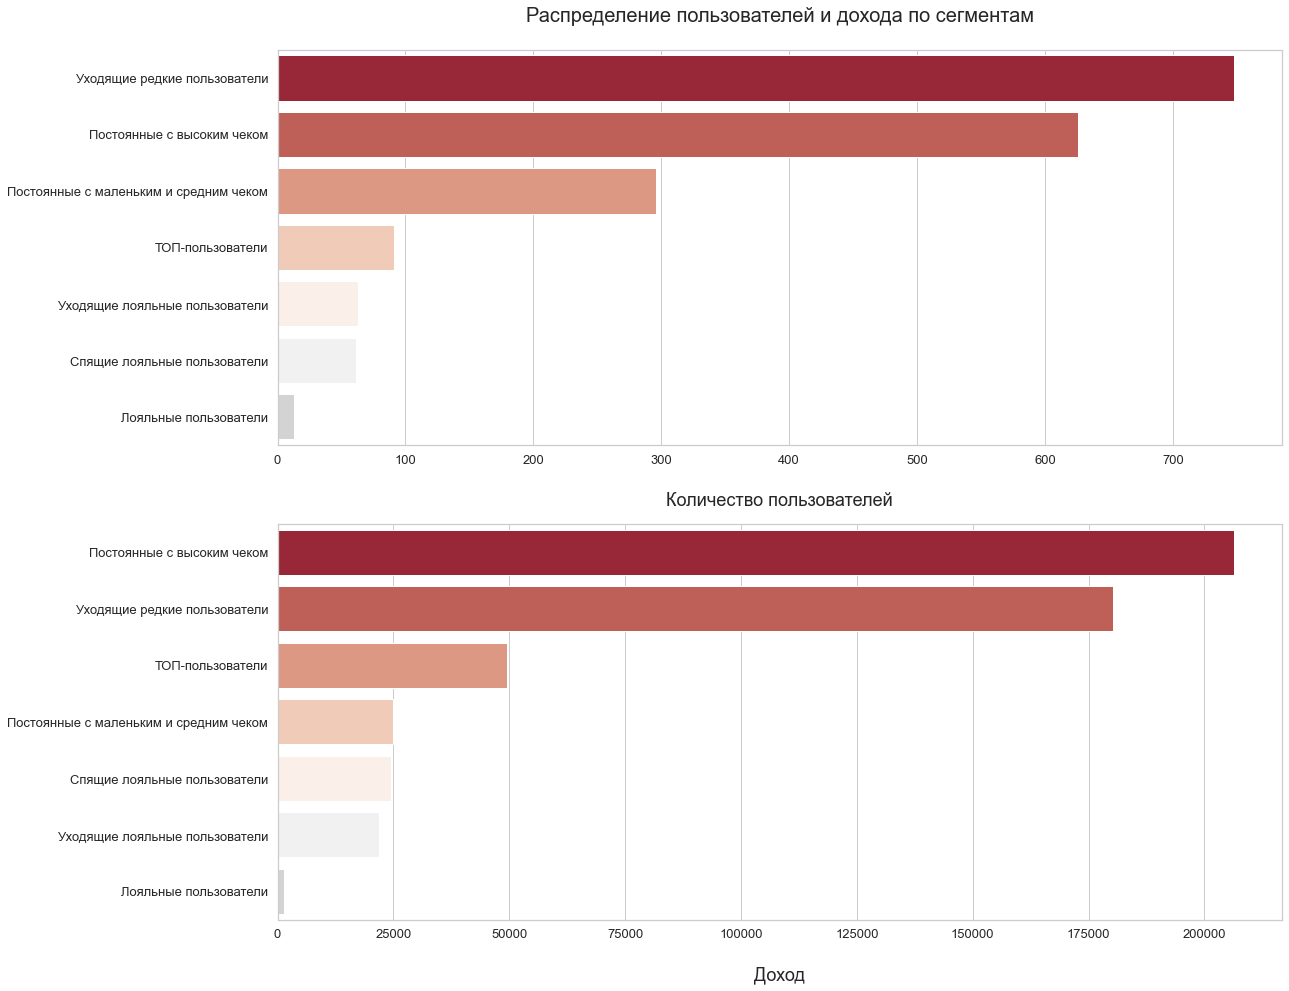

In [96]:
# Визуализируем распределение количества пользователей и дохода от них по сегментам без учета ТОП-3

fig = plt.subplots(figsize=(18, 16))
plt.subplot(2, 1, 1)
sns.barplot(data=rfm[3:10], y='Segment', x='Customer_count', orient='h')
plt.xlabel('\nКоличество пользователей', fontsize=18)
plt.ylabel('')
plt.title('Распределение пользователей и дохода по сегментам\n', fontsize=20)
plt.subplot(2, 1, 2)
sns.barplot(data=rfm[3:10].sort_values('Revenue', ascending=False), y='Segment', x='Revenue', orient='h')
plt.xlabel('\nДоход', fontsize=18)
plt.ylabel('')
plt.show()

На основе данной картины уже можно сделать оценку своей аудитории. И найти способы улучшить показания.  

Например, рассмотрим ТОП-3 сегмента по показателям:
- Спящие разовые / редкие пользователи: их много, и они принесли большой доход, еще есть вероятность того, что они совершат покупку, их нужно расшевелить и замотивировать, можно послать им рассылку с акциями. 
- Новички. Нужно поддержать их интерес. Можно отправить рассылку с описанием преимуществ сервиса, ответами на частые вопросы.
- Одноразовые - это, скорее всего, уже ушедшие пользователи, не стоит тратить на них ресурсы.  

Помимо этого, например:
- ТОП-пользователи. Занимают не последнюю строчку по количеству пользователей, что не может не радовать, этих пользователей нужно беречь и сохранить их интерес. Можно отправить им особые предложения - предложить участие в программе лояльности.

Аналогично, благодаря определенным действиям, одни пользователи могут перетечь из одного сегмента в другой сегмент. 

### 5. Создадим таблицу с описанием каждого RFM-сегмента.

Для каждого RFM-сегмента построим границы метрик recency, frequency и monetary для интерпретации этих кластеров.  
Создадим таблицу с описанием каждого RFM-сегмента.

In [97]:
# Напомним границы, которые мы использовали
borders = rfm_df[['Recency', 'Monetary']].quantile([0, .3333, .6666]).reset_index(drop=True)
borders

,Recency,Monetary
0,48.0,0.85
1,197.0,58.90
2,338.0,127.90


Будем считать, что денежная валюта - доллар, так как покупка в 0.85 рублей в настоящих реалиях кажется невозможной.

In [98]:
# Создадим таблицу с описанием каждого балла

borders_df = {'R': [1, 2, 3],
              'F': [1, 2, 3],
              'M': [1, 2, 3],
              'Recency': ['от 339 дней', 'от 198 до 338 дней', 'от 48 до 197 дней'],
              'Frequency': ['1 покупка', '2 покупки', '3 и более покупки'],
              'Monetary': ['от 0.85 до 58.9 долларов', 'от 59 до 127.9 долларов', 'от 128 долларов']}
borders_df = pd.DataFrame(borders_df)
borders_df

,R,F,M,Recency,Frequency,Monetary
0,1,1,1,от 339 дней,1 покупка,от 0.85 до 58.9 долларов
1,2,2,2,от 198 до 338 дней,2 покупки,от 59 до 127.9 долларов
2,3,3,3,от 48 до 197 дней,3 и более покупки,от 128 долларов


In [99]:
# Создадим таблицу со всеми возможными значениями RFM

combination_RFM = []
for v in itertools.product('123', repeat=3):
    combination_RFM.append(''.join(v))
all_RFM_Score = pd.DataFrame({'RFM_Score': combination_RFM})
all_RFM_Score.head()

,RFM_Score
0,111
1,112
2,113
3,121
4,122


In [100]:
# Приписываем соответствующие значения R, F, M

all_RFM_Score['R'], all_RFM_Score['M'], all_RFM_Score['F'] = \
    all_RFM_Score.RFM_Score.str[0], all_RFM_Score.RFM_Score.str[1], all_RFM_Score.RFM_Score.str[2]
all_RFM_Score = all_RFM_Score.apply(pd.to_numeric)
all_RFM_Score.head()

,RFM_Score,R,M,F
0,111,1,1,1
1,112,1,1,2
2,113,1,1,3
3,121,1,2,1
4,122,1,2,2


In [101]:
# Создаем таблицу с описанием всех RFM-сегментов

RMF_description = all_RFM_Score.merge(borders_df[['R', 'Recency']], on='R') \
    .merge(borders_df[['F', 'Frequency']], on='F') \
    .merge(borders_df[['M', 'Monetary']], on='M') \
    .sort_values('RFM_Score') \
    .reset_index(drop=True)
RMF_description.style.set_properties(subset='RFM_Score', **{'background-color': '#fceadf'})

,RFM_Score,R,M,F,Recency,Frequency,Monetary
0,111,1,1,1,от 339 дней,1 покупка,от 0.85 до 58.9 долларов
1,112,1,1,2,от 339 дней,2 покупки,от 0.85 до 58.9 долларов
2,113,1,1,3,от 339 дней,3 и более покупки,от 0.85 до 58.9 долларов
3,121,1,2,1,от 339 дней,1 покупка,от 59 до 127.9 долларов
4,122,1,2,2,от 339 дней,2 покупки,от 59 до 127.9 долларов
5,123,1,2,3,от 339 дней,3 и более покупки,от 59 до 127.9 долларов
6,131,1,3,1,от 339 дней,1 покупка,от 128 долларов
7,132,1,3,2,от 339 дней,2 покупки,от 128 долларов
8,133,1,3,3,от 339 дней,3 и более покупки,от 128 долларов
9,211,2,1,1,от 198 до 338 дней,1 покупка,от 0.85 до 58.9 долларов
